# Определение частей речи с помощью нейросети

#### Титков Даниил и Анастасия Ященко

## Введение

В данной работе мы попробуем применить нейронную сеть с архитектурой SENNA (Semantic Extraction Neural Network Architecture) [1, 3, 4]. Нейронная сеть данного типа классифицирует слова в тексте, учитывая по несколько слов, стоящих слева и справа от целевого. Это называется "окном". К примеру, при размере окна 5, нейросеть анализирует 2 предшествующих и 2 последующих слова относительно целевого. Такие модели ипользуются в основном для определения частей речи, а также для распознавания именованных сущностей. 

В авторском варианте SENNA имеет один скрытый слой, на котором расположены 100 нейронов. Слова на вход подаются в виде вектора, образованного конкатенированными эмбеддингами для слов, входящих в окно. В качестве основного преимущества SENNA авторы указывают скорость и небольшой расход памяти при сохранении точности на уровнее более требовательных моделей.

Попробуем реализовать это на практике, используя в качестве обучающего множества данные Открытого корпуса (OpenCorpora) [2].

In [1]:
from nltk.corpus.reader.conll import ConllCorpusReader

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Embedding
from keras.utils import np_utils

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(42)

from jupyterthemes import jtplot #внешний вид ноутбука и графиков
jtplot.style(theme='grade3')
%matplotlib inline

Using TensorFlow backend.


Загрузим размеченные данные Открытого корпуса русского языка [2].

In [2]:
%%time
data = ConllCorpusReader(root = '', fileids = ['unamb_sent_14_6.conllu'], 
                         columntypes = ['ignore', 'words', 'ignore', 'pos', 'chunk'])
sents = list(data.iob_sents())
print("Всего", len(sents), 'предложений')
pos_tags = set([token[1] for sent in sents for token in sent])
words = set([token[0].lower() for sent in sents for token in sent])
print("Всего", len(pos_tags), "различных тегов")
print("Всего", len(words), "уникальных слов")

Всего 38508 предложений
Всего 14 различных тегов
Всего 79791 уникальных слов
Wall time: 23.6 s


Далее загрузим эмбеддинги, предоставленный Фейсбуком. По очевидным причинам файл с эмбеддингами не присутствует в репозитории, но его легко можно найти здесь: https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.ru.vec В файле с эмебеддингами есть векторы для более чем полутора миллионов слов, поэтому, чтобы снизить нагрузку на память, мы будет сохранять только те, которые соответствуют имеющимся в корпусе словам. 

In [3]:
%%time
try:
    print('Подготовлено', len(emb_index), 'эмбеддингов')
except:
    emb_index = {}
    with open('../../wiki.ru.vec', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            if len(values) == 301 and values[0] in words:
                emb_index[values[0]] = np.asarray(values[1:], dtype='float32')
    print('Подготовлено', len(emb_index), 'эмбеддингов')

Подготовлено 70787 эмбеддингов
Wall time: 2min 27s


Определим функции, которые в дальнейшем нам пригодятся для преобразования входных данных в подходящий для модели вид. 

In [4]:
def add_padding(sent, k):
    '''добавляет паддинги в конец и начало предложений'''
    padding = ('PADDING', '_', '_') 
    for i in range(int((k-1)/2)): 
        sent.insert(0, padding)
        sent.append(padding)
    return sent

def prepx(data, k):
    '''возвращает НП в нужном виде (вектор из k конкатерированных эмебеддингов)'''
    flatten = lambda l: [item for sublist in l for item in sublist]
    vector = []
    for sent in data:
        s = []
        for i, token in enumerate(sent):
            if token[0] != 'PADDING':
                features = []
                for j in range(-int((k-1)/2), int((k-1)/2)+1):
                    features.append(sent[i+j][1])
                features = np.concatenate(features)
                s.append(features)
        vector.append(s)
    return np.asarray(flatten(vector))

def string_to_data(s):
    '''преобразует произвольное предложение в формат входных данных'''
    return [(t, 'UNK', '_') for t in s.split()]

## Модель 1 

Для первого эксперимента воспользуемся параметрами, предложенными Ронаном Коллобертом, автором архитектуры SENNA: размер окна - 5, 128 (в оригинале - 100) нейронов на скрытом слое, функция активации - гиперболический тангенс [1].

In [5]:
k = 5
EMB_DIM = 300
EPOCHS = 10
BATCH = 32
NHIDDEN = 128
ACT_FUN = 'tanh'

ntags = len(set(pos_tags))

Так как формат данных зависит от параметров модели (от размера окна), предобработку данных нужно будет производить для каждой модели отдельно.

В начало и в конец каждого предложения добавим специальные токены PADDING в количестве *(k-1)/2*. Это нужно для того, чтобы для слов, перед которыми или после которых нет других слов, модель также получала данные в правильной форме (k конкатенированных эмбеддингов, где эмбеддинг для целевого слова стоит в середине). Этим токенам будут соотвестовать векторы из нулей. Выделим 25% корпуса в качестве тестового подмножества и преобразуем данные.

In [6]:
%%time
sents_padded = [[token[0:2] for token in sent] \
                for sent in [add_padding(sent, k) for sent in sents]]

sents_emb = []
for sent in sents_padded:
    s = []
    for token in sent:
        if token[0] == 'PADDING' or emb_index.get(token[0].lower()) is None:
            s.append((token[0], np.zeros(300), token[1]))
        elif emb_index.get(token[0].lower()) is not None:
            s.append((token[0], emb_index.get(token[0].lower()), token[1]))
    sents_emb.append(s)

train, test = sents_emb[:int(len(sents_emb)*0.75)], sents_emb[int(len(sents_emb)*0.75):]
print(len(train), "предложений - обучающее множество")
print(len(test), "предложений - тестовое множество")

X_train = prepx(train, k)
X_test = prepx(test, k)
y_train_str = [t[2] for sent in train for t in sent if t[0] != "PADDING"]
y_test_str = [t[2] for sent in test for t in sent if t[0] != "PADDING"]

le = LabelEncoder()
le.fit(np.asarray(list(set(y_train_str)), dtype='object'))
y_train = np_utils.to_categorical(le.transform(y_train_str), ntags)
y_test = np_utils.to_categorical(le.transform(y_test_str), ntags)

print('X_train', 'X_test', 'y_train', 'y_test')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

28881 предложений - обучающее множество
9627 предложений - тестовое множество
X_train X_test y_train y_test
(350355, 1500) (107228, 1500) (350355, 14) (107228, 14)
Wall time: 1min 29s


Зададим архитектуру модели в соответствии с описанными выше спецификациями и запустим обучение. 

In [7]:
%%time
model1 = Sequential()
model1.add(Dense(NHIDDEN, input_shape=(EMB_DIM*k,), activation = ACT_FUN))
model1.add(Dropout(0.1))
model1.add(Dense(ntags, activation = 'softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=0.1, verbose=1)

Train on 315319 samples, validate on 35036 samples
Epoch 1/10
315319/315319 [==============================] - 635s - loss: 0.2827 - acc: 0.9126 - val_loss: 0.2781 - val_acc: 0.9153
Epoch 2/10
315319/315319 [==============================] - 93s - loss: 0.1838 - acc: 0.9420 - val_loss: 0.2509 - val_acc: 0.9225
Epoch 3/10
315319/315319 [==============================] - 91s - loss: 0.1527 - acc: 0.9512 - val_loss: 0.2493 - val_acc: 0.9247
Epoch 4/10
315319/315319 [==============================] - 91s - loss: 0.1334 - acc: 0.9573 - val_loss: 0.2450 - val_acc: 0.9269
Epoch 5/10
315319/315319 [==============================] - 81s - loss: 0.1187 - acc: 0.9615 - val_loss: 0.2535 - val_acc: 0.9278
Epoch 6/10
315319/315319 [==============================] - 76s - loss: 0.1063 - acc: 0.9655 - val_loss: 0.2598 - val_acc: 0.9285
Epoch 7/10
315319/315319 [==============================] - 76s - loss: 0.0969 - acc: 0.9681 - val_loss: 0.2608 - val_acc: 0.9290
Epoch 8/10
315319/315319 [============

Видим, что уже после 3-й эпохи не наблюдается существенного роста качества классификации. Поэтому в следующих моделях будем использовать меньше эпох.
Посмотрим, какова точность определения частей речи на тестовом множестве.

In [8]:
y_pred = model1.predict_classes(X_test)
y_pred_str = le.inverse_transform(y_pred)
print('\n'*2, 'Accuracy =', accuracy_score(y_test_str, y_pred_str))
print(classification_report(y_test_str, y_pred_str))

107136/107228 [============================>.] - ETA: 0s

 Accuracy = 0.941759615026
             precision    recall  f1-score   support

        ADJ       0.94      0.94      0.94     11684
        ADP       0.99      0.99      0.99      9314
        ADV       0.90      0.90      0.90      2833
       CONJ       0.96      0.98      0.97      5223
        DET       0.94      0.96      0.95      2602
       INTJ       0.74      0.55      0.63       106
       NOUN       0.96      0.97      0.97     30675
        NUM       0.71      0.81      0.76      2115
       PART       0.96      0.87      0.92      1775
       PRON       0.97      0.97      0.97      1792
      PROPN       0.80      0.82      0.81      2579
      PUNCT       0.98      0.97      0.98     22669
       VERB       0.95      0.97      0.96      8849
          X       0.70      0.61      0.65      5012

avg / total       0.94      0.94      0.94    107228



Как видно из репорта, качествео классификации составляет примерно 94%. Больше всего ошибок делается в отношении междометий, что закономерно, так как они являются самым малочисленными классом. Также хуже других частей речи распознаются числительные. Построим матрицу ошибок, чтобы посмотреть, какие части речи модель "путает" чаще всего.

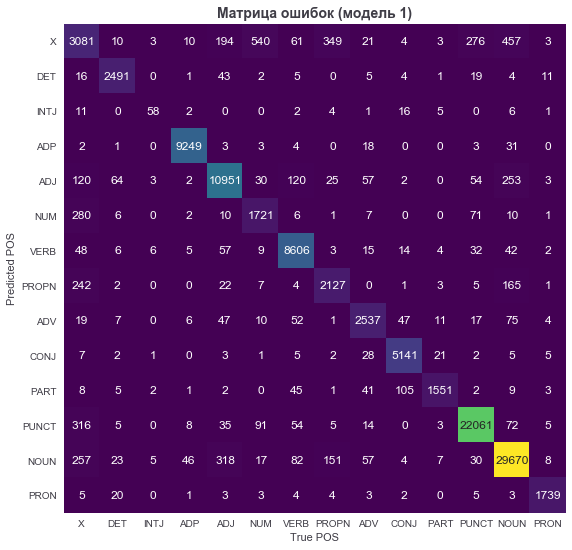

In [9]:
labels = list(set(y_test_str))
sns.set_context("notebook")
plt.figure(figsize=(9,9))
sns.heatmap(data=confusion_matrix(y_test_str, y_pred_str, labels = labels), 
            annot=True, fmt="d", cbar=False, 
            xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.xlabel('True POS')
plt.ylabel('Predicted POS')
plt.title(('Матрица ошибок (модель 1)'), fontsize=14, fontweight='bold');
plt.show()

Из матрицы видно, что чаще всего числительные путаются с со словами части речи "X", что соотвествует неопределенной части речи. Этот класс вообще служит источником наибольшего числа смешений, что в свою очередь тоже закономерно.

## Модель 2 - окно меньшего размера

Повторим эксперимент с теми же параметрами, однако на этот раз размер окна будет не 5, а 3. 

In [10]:
k = 3
EMB_DIM = 300
EPOCHS = 8
BATCH = 32
NHIDDEN = 128
ACT_FUN = 'tanh'

ntags = len(set(pos_tags))

In [11]:
%%time
sents = list(data.iob_sents())
sents_padded = [[token[0:2] for token in sent] \
                for sent in [add_padding(sent, k) for sent in sents]]

sents_emb = []
for sent in sents_padded:
    s = []
    for token in sent:
        if token[0] == 'PADDING' or emb_index.get(token[0].lower()) is None:
            s.append((token[0], np.zeros(300), token[1]))
        elif emb_index.get(token[0].lower()) is not None:
            s.append((token[0], emb_index.get(token[0].lower()), token[1]))
    sents_emb.append(s)

train, test = sents_emb[:int(len(sents_emb)*0.75)], sents_emb[int(len(sents_emb)*0.75):]
print(len(train), "предложений - обучающее множество")
print(len(test), "предложений - тестовое множество")

X_train = prepx(train, k)
X_test = prepx(test, k)
y_train_str = [t[2] for sent in train for t in sent if t[0] != "PADDING"]
y_test_str = [t[2] for sent in test for t in sent if t[0] != "PADDING"]

le = LabelEncoder()
le.fit(np.asarray(list(set(y_train_str)), dtype='object'))
y_train = np_utils.to_categorical(le.transform(y_train_str), ntags)
y_test = np_utils.to_categorical(le.transform(y_test_str), ntags)

print('X_train', 'X_test', 'y_train', 'y_test')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

28881 предложений - обучающее множество
9627 предложений - тестовое множество
X_train X_test y_train y_test
(350355, 900) (107228, 900) (350355, 14) (107228, 14)
Wall time: 3min 9s


In [12]:
%%time
model2 = Sequential()
model2.add(Dense(NHIDDEN, input_shape=(EMB_DIM*k,), activation = ACT_FUN))
model2.add(Dropout(0.1))
model2.add(Dense(ntags, activation = 'softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=0.1, verbose=1)

Train on 315319 samples, validate on 35036 samples
Epoch 1/8
315319/315319 [==============================] - 199s - loss: 0.2690 - acc: 0.9177 - val_loss: 0.2678 - val_acc: 0.9180
Epoch 2/8
315319/315319 [==============================] - 59s - loss: 0.1817 - acc: 0.9428 - val_loss: 0.2436 - val_acc: 0.9258
Epoch 3/8
315319/315319 [==============================] - 56s - loss: 0.1554 - acc: 0.9507 - val_loss: 0.2406 - val_acc: 0.9279
Epoch 4/8
315319/315319 [==============================] - 57s - loss: 0.1377 - acc: 0.9563 - val_loss: 0.2315 - val_acc: 0.9322
Epoch 5/8
315319/315319 [==============================] - 54s - loss: 0.1260 - acc: 0.9593 - val_loss: 0.2240 - val_acc: 0.9332
Epoch 6/8
315319/315319 [==============================] - 57s - loss: 0.1162 - acc: 0.9626 - val_loss: 0.2259 - val_acc: 0.9340
Epoch 7/8
315319/315319 [==============================] - 55s - loss: 0.1083 - acc: 0.9646 - val_loss: 0.2292 - val_acc: 0.9353
Epoch 8/8
315319/315319 [====================

In [13]:
y_pred = model2.predict_classes(X_test)
y_pred_str = le.inverse_transform(y_pred)
print('\n'*2, 'Accuracy =', accuracy_score(y_test_str, y_pred_str))
print(classification_report(y_test_str, y_pred_str))

106784/107228 [============================>.] - ETA: 0s

 Accuracy = 0.946739657552
             precision    recall  f1-score   support

        ADJ       0.96      0.94      0.95     11684
        ADP       0.99      0.99      0.99      9314
        ADV       0.91      0.92      0.91      2833
       CONJ       0.97      0.98      0.98      5223
        DET       0.98      0.97      0.97      2602
       INTJ       0.93      0.48      0.63       106
       NOUN       0.96      0.98      0.97     30675
        NUM       0.75      0.81      0.78      2115
       PART       0.95      0.92      0.93      1775
       PRON       0.98      0.98      0.98      1792
      PROPN       0.85      0.82      0.83      2579
      PUNCT       0.97      0.97      0.97     22669
       VERB       0.96      0.97      0.97      8849
          X       0.68      0.66      0.67      5012

avg / total       0.95      0.95      0.95    107228



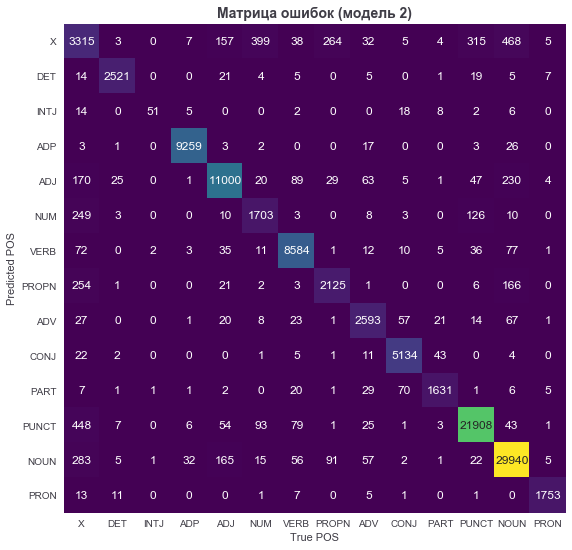

In [14]:
labels = list(set(y_test_str))
sns.set_context("notebook")
plt.figure(figsize=(9,9))
sns.heatmap(data=confusion_matrix(y_test_str, y_pred_str, labels = labels), 
            annot=True, fmt="d", cbar=False, 
            xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.xlabel('True POS')
plt.ylabel('Predicted POS')
plt.title(('Матрица ошибок (модель 2)'), fontsize=14, fontweight='bold');
plt.show()

Видим, что модель с размером окна k=3 дает результат как минимум не хуже (лучше на ~0.5%), чем модель с размером окна k=5. При этом обучается и работает такая модель быстрее. 

## Модель 3 - линейная функция активации

Теперь выберем более эффективную модель из опробованных (с размером окна k=3) и изменим функцию активации. 

In [15]:
k = 3
EMB_DIM = 300
EPOCHS = 8
BATCH = 32
NHIDDEN = 128
ACT_FUN = 'relu'

ntags = len(set(pos_tags))

In [16]:
%%time
model3 = Sequential()
model3.add(Dense(NHIDDEN, input_shape=(EMB_DIM*k,), activation = ACT_FUN))
model3.add(Dropout(0.1))
model3.add(Dense(ntags, activation = 'softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=0.1, verbose=1)

Train on 315319 samples, validate on 35036 samples
Epoch 1/8
315319/315319 [==============================] - 59s - loss: 0.2613 - acc: 0.9196 - val_loss: 0.2399 - val_acc: 0.9256
Epoch 2/8
315319/315319 [==============================] - 58s - loss: 0.1602 - acc: 0.9494 - val_loss: 0.2207 - val_acc: 0.9301
Epoch 3/8
315319/315319 [==============================] - 56s - loss: 0.1331 - acc: 0.9571 - val_loss: 0.2196 - val_acc: 0.9348
Epoch 4/8
315319/315319 [==============================] - 54s - loss: 0.1172 - acc: 0.9619 - val_loss: 0.2238 - val_acc: 0.9345
Epoch 5/8
315319/315319 [==============================] - 53s - loss: 0.1053 - acc: 0.9653 - val_loss: 0.2304 - val_acc: 0.9346
Epoch 6/8
315319/315319 [==============================] - 54s - loss: 0.0962 - acc: 0.9680 - val_loss: 0.2336 - val_acc: 0.9369
Epoch 7/8
315319/315319 [==============================] - 55s - loss: 0.0902 - acc: 0.9701 - val_loss: 0.2396 - val_acc: 0.9350
Epoch 8/8
315319/315319 [=====================

In [17]:
y_pred = model3.predict_classes(X_test)
y_pred_str = le.inverse_transform(y_pred)
print('\n'*2, 'Accuracy =', accuracy_score(y_test_str, y_pred_str))
print(classification_report(y_test_str, y_pred_str))

106528/107228 [============================>.] - ETA: 0s

 Accuracy = 0.946581116872
             precision    recall  f1-score   support

        ADJ       0.96      0.94      0.95     11684
        ADP       1.00      0.99      0.99      9314
        ADV       0.93      0.90      0.92      2833
       CONJ       0.98      0.97      0.98      5223
        DET       0.95      0.97      0.96      2602
       INTJ       0.73      0.59      0.66       106
       NOUN       0.96      0.98      0.97     30675
        NUM       0.67      0.84      0.75      2115
       PART       0.94      0.92      0.93      1775
       PRON       0.99      0.97      0.98      1792
      PROPN       0.85      0.81      0.83      2579
      PUNCT       0.97      0.97      0.97     22669
       VERB       0.97      0.97      0.97      8849
          X       0.72      0.61      0.66      5012

avg / total       0.95      0.95      0.95    107228



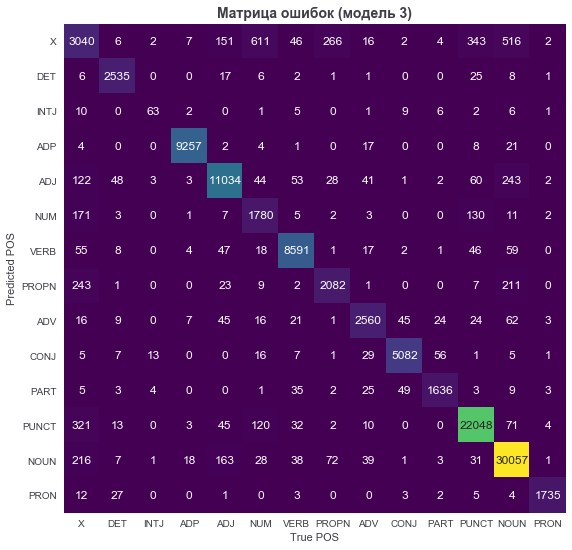

In [18]:
labels = list(set(y_test_str))
sns.set_context("notebook")
plt.figure(figsize=(9,9))
sns.heatmap(data=confusion_matrix(y_test_str, y_pred_str, labels = labels), 
            annot=True, fmt="d", cbar=False, 
            xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.xlabel('True POS')
plt.ylabel('Predicted POS')
plt.title(('Матрица ошибок (модель 3)'), fontsize=14, fontweight='bold');
plt.show()

Видно, что изменение функции активации не привело к изменению качества классификации, но немного сократило время обучения. 

## Модель 4 - меньше нейронов

Наконец, сократим количество нейронов на скрытом слое и посмотрим, куда это нас приведет. 

In [19]:
k = 3
EMB_DIM = 300
EPOCHS = 8
BATCH = 32
NHIDDEN = 32
ACT_FUN = 'relu'

ntags = len(set(pos_tags))

In [20]:
%%time
model4 = Sequential()
model4.add(Dense(NHIDDEN, input_shape=(EMB_DIM*k,), activation = ACT_FUN))
model4.add(Dropout(0.1))
model4.add(Dense(ntags, activation = 'softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=0.1, verbose=1)

Train on 315319 samples, validate on 35036 samples
Epoch 1/8
315319/315319 [==============================] - 30s - loss: 0.3262 - acc: 0.9013 - val_loss: 0.2773 - val_acc: 0.9147
Epoch 2/8
315319/315319 [==============================] - 30s - loss: 0.2076 - acc: 0.9342 - val_loss: 0.2528 - val_acc: 0.9225
Epoch 3/8
315319/315319 [==============================] - 30s - loss: 0.1868 - acc: 0.9409 - val_loss: 0.2468 - val_acc: 0.9244
Epoch 4/8
315319/315319 [==============================] - 30s - loss: 0.1763 - acc: 0.9438 - val_loss: 0.2467 - val_acc: 0.9254
Epoch 5/8
315319/315319 [==============================] - 30s - loss: 0.1682 - acc: 0.9460 - val_loss: 0.2420 - val_acc: 0.9284
Epoch 6/8
315319/315319 [==============================] - 30s - loss: 0.1624 - acc: 0.9476 - val_loss: 0.2410 - val_acc: 0.9276
Epoch 7/8
315319/315319 [==============================] - 30s - loss: 0.1578 - acc: 0.9489 - val_loss: 0.2433 - val_acc: 0.9282
Epoch 8/8
315319/315319 [=====================

In [21]:
y_pred = model4.predict_classes(X_test)
y_pred_str = le.inverse_transform(y_pred)
print('\n'*2, 'Accuracy =', accuracy_score(y_test_str, y_pred_str))
print(classification_report(y_test_str, y_pred_str))

106752/107228 [============================>.] - ETA: 0s

 Accuracy = 0.941461185511
             precision    recall  f1-score   support

        ADJ       0.95      0.93      0.94     11684
        ADP       0.99      0.99      0.99      9314
        ADV       0.91      0.89      0.90      2833
       CONJ       0.97      0.97      0.97      5223
        DET       0.96      0.96      0.96      2602
       INTJ       0.94      0.27      0.42       106
       NOUN       0.96      0.97      0.96     30675
        NUM       0.73      0.82      0.77      2115
       PART       0.93      0.89      0.91      1775
       PRON       0.98      0.97      0.98      1792
      PROPN       0.82      0.81      0.81      2579
      PUNCT       0.97      0.97      0.97     22669
       VERB       0.96      0.97      0.96      8849
          X       0.70      0.62      0.66      5012

avg / total       0.94      0.94      0.94    107228



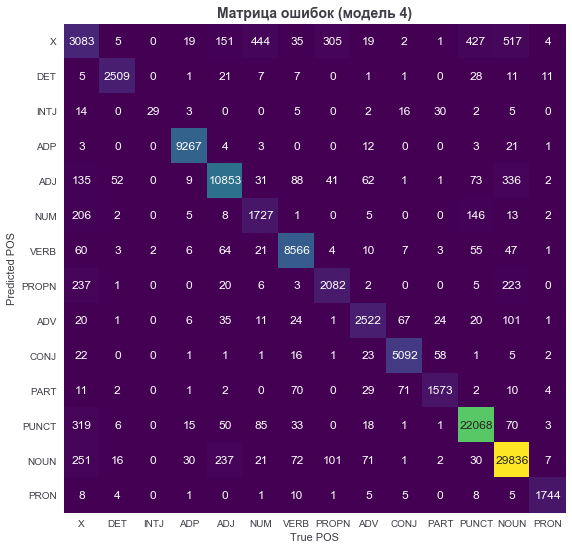

In [22]:
labels = list(set(y_test_str))
sns.set_context("notebook")
plt.figure(figsize=(9,9))
sns.heatmap(data=confusion_matrix(y_test_str, y_pred_str, labels = labels), 
            annot=True, fmt="d", cbar=False, 
            xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.xlabel('True POS')
plt.ylabel('Predicted POS')
plt.title(('Матрица ошибок (модель 4)'), fontsize=14, fontweight='bold');
plt.show()

Сокращение количества нейронов на скрытом слое в 4 раза (с 128 до 32) приводит к уменьшению качества классификации приблизительно на 0.5%. Закадровые опыты показали, что конфигурации вплоть до 8 нейронов не приводят к значительному снижению клачества классификации.

## Проверка на произвольных предложениях

Наконец, попробуем нашу третью модель (как самую эффективную) на проивольных предолжениях и посмотрим на результат

In [23]:
%%time
c = ['''Кто даст мне вкусный обед : суп с мясом и поспать ?
    Олег пошел в пустыню Каракум и поймал орнитоптера ( красного ) .
    Хотелось бы стремиться к большему , жить на полную картошку''']
control = [string_to_data(s) for s in c]
control_padded = [[token[0:2] for token in sent] \
                for sent in [add_padding(sent, k) for sent in control]]

control_emb = []
for sent in control_padded:
    s = []
    for token in sent:
        if token[0] == 'PADDING' or emb_index.get(token[0].lower()) is None:
            s.append((token[0], np.zeros(300), token[1]))
        elif emb_index.get(token[0].lower()) is not None:
            s.append((token[0], emb_index.get(token[0].lower()), token[1]))
    control_emb.append(s)
    
X_control = prepx(control_emb, k)

Wall time: 62.5 ms


In [24]:
y_control_pred = model3.predict_classes(X_control)
y_control_pred_str = le.inverse_transform(y_control_pred)
print()
for sent in [string_to_data(s) for s in c]:
    for i, token in enumerate(sent):
        print((token[0], y_control_pred_str[i]))

32/34 [===========================>..] - ETA: 0s
('Кто', 'PRON')
('даст', 'VERB')
('мне', 'PRON')
('вкусный', 'PUNCT')
('обед', 'NOUN')
(':', 'PUNCT')
('суп', 'NOUN')
('с', 'ADP')
('мясом', 'NOUN')
('и', 'CONJ')
('поспать', 'VERB')
('?', 'PUNCT')
('Олег', 'PROPN')
('пошел', 'VERB')
('в', 'ADP')
('пустыню', 'NOUN')
('Каракум', 'X')
('и', 'CONJ')
('поймал', 'X')
('орнитоптера', 'NUM')
('(', 'PUNCT')
('красного', 'ADJ')
(')', 'PUNCT')
('.', 'PUNCT')
('Хотелось', 'VERB')
('бы', 'PART')
('стремиться', 'VERB')
('к', 'ADP')
('большему', 'ADJ')
(',', 'PUNCT')
('жить', 'VERB')
('на', 'ADP')
('полную', 'ADJ')
('картошку', 'NOUN')


Для большинства слов модель сделала корректные предсказания. Имя собственное "Каракум", которого нет в обучающем корпусе, классифицировано условно правильно как имеющее неизвестную часть речи (тем же тегом в корпусе отмечены многие собственные имена). Неожиданно ошибочно определены казалось бы простые слова "вкусный" и "поймал". Эти слова, тем не менее, отсутствуют в корпусе. 

Такой результат возвращает нас к рассуждению о специфике текстов, включенных в Открытый корпус (преимущественно новостные статьи), которая делает его не репрезентативным для многих практически важных контекстов (для справки: самой частотной биграммой в нем является "Российская Федерация"). 

## Заключение

Наше небольшое исследование показало, что архитектура нейронной сети SENNA, предложенная Ронаном Коллобертом, подходит для определения частей речи в русском языке и позволяет получить в этой задаче точность около 95%, что примерно соответствует результатам, которые можно получить с помощью условных случайных полей. Также по результатам наших опытом получается, что 100 нейронов на скрытом слое не требуется, достаточно меньшего количества.

Стоит обратить внимание на то, что данные открытого корпуса в ряде отношений оставляют желать лучшего. Так, спектр тематик текстов в нем органичен, а также имеется много слов с частеречным тегом X, которым обозначены слова, реально имеющие разные части речи. Этот тег является наиболее существенным источником ошибок модели. Стоит ожидать, что использование более качественного корпуса для обучения модели может дать лучшие результаты.

## Источники

1. https://github.com/UKPLab/deeplearning4nlp-tutorial/blob/master/2016-11_Seminar/Session%201%20-%20SENNA/SENNA.pdf
2. Открытый корпус http://opencorpora.org/
3. http://www.nec-labs.com/research-departments/machine-learning/machine-learning-software/Senna